In [1]:
import scanpy as sc
import pycisTopic
from pycisTopic.cistopic_class import *
import pickle
import os
import anndata
import mudata
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyvis.network import Network


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
def visualize_regulatory_network(metadata_df, importance_col='importance', weight_col='importance_TF2G',
                               top_n=100, output_html='figures/network.html',title='SCENIC+ Regulatory Network',df_deg=None):
    """
    Visualize SCENIC+ regulatory network with TF-gene relationships
    
    Parameters:
        metadata_df: DataFrame with columns ['TF', 'gene', importance_col, 'region']
        importance_col: Column name for TF-gene importance scores
        top_n: Number of top interactions to visualize
        output_html: Output file name for interactive visualization
    """
    # Prepare data
    # Sort by the absolute importance and select top_n interactions

    df = metadata_df.sort_values(importance_col, ascending=False).head(top_n)
    #df = metadata_df.sort_values(importance_col, ascending=False)
    
    # Create network graph
    G = nx.DiGraph()
    
    # Add nodes and edges with importance as weight
    for _, row in df.iterrows():
        G.add_edge(row['TF'], row['Gene'], 
                  weight=row[weight_col],
                  title=f"Importance: {row[weight_col]:.2f}")
        
    degrees = dict(G.degree())
    max_degree = max(degrees.values()) if degrees else 1

    
    # Node colors (TFs in red, genes in blue)
    # Node colores, where TFs are orange and genes are magenta, not in df_deg are gray

    node_colors = {}
    for node in G.nodes():
        if node in df['TF'].unique() and node in df_deg['gene'].unique():
            if df_deg[df_deg['gene'] == node]['condition'].values[0] == 'UP':
                node_colors[node] = 'orange'
            else:
                node_colors[node] = 'yellow'
        elif node in df['Gene'].unique() and node in df_deg['gene'].unique():
            if df_deg[df_deg['gene'] == node]['condition'].values[0] == 'UP':
                node_colors[node] = 'magenta'
            else:
                node_colors[node] = 'pink'
        else:
            node_colors[node] = 'lightgray'  # For nodes not in df_deg
    # node_colors = {
    #     node: 'orange' if node in df['TF'].unique() else 'magenta'
    #     for node in G.nodes()
    # }
    
    # Static visualization
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    
    # Draw nodes

    node_sizes = [degrees[n] * 800 / max_degree for n in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_color=[node_colors[n] for n in G.nodes()],
                          node_size=node_sizes, alpha=0.8)

    # Draw edges with width proportional to importance
    edge_widths = [d['weight']*2 for u, v, d in G.edges(data=True)]
    # nx.draw_networkx_edges(G, pos, width=edge_widths, 
    #                       edge_color='gray', alpha=0.6, 
    #                       arrowstyle='-|>', arrowsize=15)
    for u, v, d in G.edges(data=True):
        arrowstyle = '-|>' if d['weight'] >= 0 else '-['
        color = 'gray' if d['weight'] >= 0 else 'pink'
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            width=abs(d['weight'])*2,
            edge_color=color,
            alpha=0.6,
            arrowstyle=arrowstyle,
            arrowsize=15
        )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_html+".png", dpi=300)
    plt.show()
    
    # Interactive visualization
    net = Network(height='800px', width='100%', directed=True)
    net.from_nx(G)
    
    # Set node colors and sizes
    # for node in net.nodes:
    #     node['color'] = 'red' if node['label'] in df['TF'].unique() else 'blue'
    #     node['size'] = 20 if node['label'] in df['TF'].unique() else 15
    

    # for edge in net.edges:
    #     weight = G.edges[edge['from'], edge['to']]['weight']
    #     if weight >= 0:
    #         edge['color'] = {'color': 'green', 'highlight': 'lime'}
    #         edge['arrows'] = 'to'
    #     else:
    #         edge['color'] = {'color': 'lightblue', 'highlight': 'lightblue'}  # Changed to lightblue
    #         edge['arrows'] = 'to'
    #         edge['dashes'] = True

    # Save interactive version
    net.show_buttons(filter_=['physics'])
    net.save_graph(output_html)
    print(f"Interactive visualization saved to {output_html}")

# Example usage with test data
# if __name__ == "__main__":
    # Create test data matching SCENIC+ format
# test_data = {
#     'TF': ['TF1', 'TF1', 'TF2', 'TF2', 'TF3', 'TF3'],
#     'gene': ['GeneA', 'GeneB', 'GeneC', 'GeneD', 'GeneE', 'GeneF'],
#     'importance': [0.9, 0.8, 0.7, 0.6, 0.5, 0.4],
#     'region': ['chr1:100-200', 'chr1:300-400', 'chr2:100-200', 
#                 'chr3:100-200', 'chr4:100-200', 'chr5:100-200']
# }


In [3]:
cac_gene_dict = {'α1 subunit': ['Cacna1a',
  'Cacna1b',
  'Cacna1c',
  'Cacna1d',
  'Cacna1e',
  'Cacna1g',
  'Cacna1h',
  'Cacna1i'],
 'α2δ subunit': ['Cacna2d1', 'Cacna2d2', 'Cacna2d3', 'Cacna2d4'],
 'β subunit': ['Cacnb1', 'Cacnb2', 'Cacnb3', 'Cacnb4'],
 'γ subunit': ['Cacng2', 'Cacng3', 'Cacng4', 'Cacng5', 'Cacng7', 'Cacng8'],
 'None': ['Cacfd1', 'Cachd1']}

ca_genes = ['Cacna1a', 'Cacna1b', 'Cacna1c', 'Cacna1d', 'Cacna1e', 'Cacna1g', 
            'Cacna1h', 'Cacna1i', 'Cacna2d1', 'Cacna2d2', 'Cacna2d3', 'Cacna2d4', 
            'Cacnb1', 'Cacnb2', 'Cacnb3', 'Cacnb4', 'Cacng2', 'Cacng3', 'Cacng4', 
            'Cacng5', 'Cacng7', 'Cacng8', 'Cacfd1', 'Cachd1']


ligand = ['Slc18a2', 'Slc18a1', 'Ddc', 'Th', 'Slc17a7', 'Slc17a8', 'Gls',
       'Slc17a6', 'Slc18a3', 'Chat', 'Slc32a1', 'Dbh', 'Tph2', 'Tph1', 'Gad2',
       'Gad1', 'Pnmt', 'Shmt2', 'Shmt1', 'Hmox2', 'Nos3', 'Hmox1', 'Cort',
       'Nos2', 'Nos1', 'Sst', 'Adcyap1', 'Rln1', 'Nrxn3', 'Npy', 'Nrxn2',
       'Nrxn1', 'Pdyn', 'Vip', 'Trh', 'Crh', 'Nts', 'Penk', 'Tac1', 'Pthlh',
       'Pnoc', 'Tac2', 'Gjc1', 'Gjc2', 'Gjc3', 'Gjd2', 'Gjd3', 'Gjd4', 'Gje1',
       'Gjb6', 'Gjb5', 'Gjb4', 'Gjb3', 'Gjb2', 'Gjb1', 'Gja8', 'Gja6', 'Cck',
       'Grp', 'Gja5', 'Gja4', 'Gja1', 'Gja3', 'Gja10', 'Nmb']

receptor = ['Oprl1', 'Gabra6', 'Grik3', 'Gabrb3', 'Grik5', 'Adrb1', 'Oprd1', 'Gabra4', 
            'Grm5', 'Drd4', 'Npy1r', 'Grin2c', 'Slc6a4', 'Gjc3', 'Chrna7', 'Rxfp1', 'Adra1b', 
            'Gjb1', 'Oprm1', 'Nlgn2', 'Drd5', 'Chrm5', 'Gabra1', 'Htr5a', 'Pth1r', 'Oprk1', 'Tacr3', 
            'Chrna1', 'Grm7', 'Grik2', 'Chrna6', 'Adra1a', 'Gucy1b2', 'Slc6a3', 'Adra2b', 'Gabbr1', 'Chrna4', 
            'Gjb4', 'Htr1b', 'Gja1', 'Npy2r', 'Gucy1a1', 'Gabrb1', 'Grin1', 'Adra2a', 'Tacr1', 'Adrb2', 'Sstr2', 
            'Grin3a', 'Glra2', 'Slc6a2', 'Drd3', 'Htr1d', 'Adra2c', 'Htr2c', 'Grin2d', 'Chrnb1', 'Chrnb2', 'Gja4', 'Htr7', 
            'Htr2b', 'Gabra3', 'Ache', 'Grik4', 'Htr6', 'Grm1', 'Sstr4', 'Gjb2', 'Grm6', 'Adcyap1r1', 'Adra1d', 'Gria2', 
            'Chrna2', 'Grm3', 'Grik1', 'Chrm3', 'Rxfp3', 'Chrna10', 'Chrng', 'Gjb3', 'Crhr2', 'Grin3b', 'Gria3', 'Vipr1', 'Gria1', 
            'Grin2b', 'Htr4', 'Slc6a9', 'Npy5r', 'Gja3', 'Htr1f', 'Chrnb3', 'Gjd4', 'Nlgn3', 'Gjd2', 'Grm4', 'Sstr1', 'Grin2a', 'Gabrg2', 
            'Adrb3', 'Grm2', 'Gja8', 'Glra3', 'Gje1', 'Comt', 'Sstr3', 'Gjb5', 'Gabra2', 'Rxfp2', 'Chrne', 'Gabrg3', 'Vipr2', 'Cckbr', 'Htr1a', 
            'Chrm2', 'Gucy1a2', 'Htr2a', 'Ntsr2', 'Ntsr1', 'Htr3b', 'Gabrb2', 'Gja6', 'Drd2', 'Glra1', 'Grm8', 'Chrnd', 'Nmbr', 'Glrb', 'Trhr', 
            'Gria4', 'Gja5', 'Chrna9', 'Gucy1b1', 'Nlgn1', 'Drd1', 'Gjc1', 'Glra4', 'Crhr1', 'Chrna5', 'Gjc2', 'Gjd3', 'Trhr2', 'Gabra5', 'Htr1e', 
            'Htr3a', 'Slc6a5', 'Gja10', 'Chrna3', 'Chrm4', 'Gjb6', 'Chrnb4', 'Chrm1', 'Gabrg1', 'Gabbr2', 'Grpr']


respriotory = ['mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Atp6', 'mt-Nd4', 'mt-Nd1', 'Cox6c',
       'Cox8a', 'Cox4i1', 'Sdha', 'Ndufa4', 'Ndufs4', 'Cox7c', 'Ndufc2',
       'Ndufaf7', 'Ndufa13', 'Atp5f1', 'Ndufaf4', 'Cox7a2', 'Cox7b', 'Cox6a1',
       'Ndufs1', 'Ndufv2', 'Ndufb5', 'Uqcrh', 'Uqcrc2', 'Ndufaf2', 'Ndufb9',
       'Cox5a', 'Ndufa10', 'Ndufb1-ps', 'mt-Nd2', 'Ndufa6', 'Cox5b', 'Ndufb11',
       'Ndufb3', 'Cox6b1', 'Ndufs3', 'Uqcrq', 'Cyc1', 'Ndufb4', 'Coq2', 'Sdhb',
       'Ndufa7', 'Ndufs7', 'Ndufa12', 'Ndufb8', 'Ndufa11', 'Ndufb10', 'Ndufa3',
       'Coa3', 'Uqcrb', 'Ndufab1', 'Ndufa5', 'Uqcrc1', 'Sod2', 'Uqcr11',
       'Uqcr10', 'Sdhc', 'Ndufb2', 'Ndufa2', 'Ndufv3', 'Ndufs2', 'Ndufa1',
       'Ndufb7', 'Cycs', 'Ndufv1', 'Ndufa8', 'Coq3', 'Ndufc1', 'Ndufa9',
       'Coq5', 'Ndufb6', 'Coq8b', 'Ndufs8', 'Ndufaf5', 'Coq9', 'Ndufaf6',
       'Ndufs6', 'Tfam', 'mt-Nd3', 'mt-Nd5', 'Coq4', 'Sdhd', 'Coq7', 'Ndufaf3',
       'mt-Nd4l', 'Coa5', 'Coa7', 'Cox6a2', 'Cox4i2']

In [4]:
df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)
df_deg = df_deg[df_deg['gender'] == "M"]
df_deg = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M") & (df_deg.region.isin(['AMY','HIP','PFC']))]
df_deg['condition'] = 'DOWN'
df_deg.loc[df_deg.de_coef>0,'condition'] = 'UP'

In [8]:
df_dar = pd.read_csv('/data2st1/junyi/output/atac0526/dar/region_nt/mementob_dar_noccur.csv')

In [9]:
df_dar

names    tx   de_coef     de_se       de_pval  \
0         chr2:98662628-98663129  stim  0.297648  0.040250  1.275518e-13   
1       chrX:143482812-143483313  stim  0.367096  0.049646  1.308574e-13   
2       chr6:103648949-103649450  stim  0.297753  0.040198  1.474284e-13   
3         chr2:98662045-98662546  stim  0.314090  0.042905  2.253055e-13   
4        chr12:20815539-20816040  stim  0.679751  0.098147  5.078591e-12   
...                          ...   ...       ...       ...           ...   
166087   chr13:98316774-98317275  stim -0.093560  0.047568  4.964940e-02   
166088    chr7:80688678-80689179  stim -0.104519  0.053277  4.972339e-02   
166089   chr17:66123319-66123820  stim -0.100798  0.053496  4.980623e-02   
166090    chr5:57716510-57717011  stim -0.139860  0.070286  4.997954e-02   
166091  chr5:124355286-124355787  stim -0.145295  0.072719  4.998238e-02   

         dv_coef     dv_se   dv_pval    ctname region  ...     gstart  \
0      -0.126407  0.107848  0.234857    Immune    PFC  ...   98662236   
1       0.010504  0.125507  0.992527    Immune    PFC  ...  143518590   
2      -0.144116  0.094564  0.110749    Immune    PFC  ...  103510585   
3      -0.469675  0.251926  0.074096    Immune    PFC  ...   98662236   
4      -0.045391  0.226588  0.728508    Immune    PFC  ...   20804380   
...          ...       ...       ...       ...    ...  ...        ...   
166087  0.077941  0.208111  0.741855  AMY_GABA    AMY  ...   98316421   
166088 -0.302131  0.229897  0.191148  AMY_GABA    AMY  ...   80586626   
166089  0.086841  0.205283  0.619451  AMY_GABA    AMY  ...   66123519   
166090 -0.236434  0.346212  0.444463  AMY_GABA    AMY  ...   57570081   
166091 -0.167872  0.223998  0.473177  AMY_GABA    AMY  ...  124345416   

             gend strand  annotation_x  distance   de_pval_adj primary_region  \
0        98664083      +      genebody         0  3.038415e-12           exon   
1       143797796      +      genebody     35278  3.114843e-12         distal   
2       103750211      +      genebody         0  3.496496e-12         intron   
3        98664083      +      genebody         0  5.274371e-12           exon   
4        20815779      -      genebody         0  1.072659e-10           exon   
...           ...    ...           ...       ...           ...            ...   
166087   98324415      +      genebody         0  1.344347e-01       promoter   
166088   80688877      -      genebody         0  1.345883e-01       promoter   
166089   66152174      +      genebody         0  1.347595e-01            UTR   
166090   57720201      -      genebody         0  1.351111e-01           exon   
166091  124363082      -      genebody         0  1.351164e-01       promoter   

        secondary_region                                darct n_celltype  
0                   LINE                    PFC_Glut/PFC_GABA        2.0  
1                   LINE                    PFC_Glut/PFC_GABA        2.0  
2                   LINE                    PFC_Glut/PFC_GABA        2.0  
3                 repeat                    PFC_Glut/PFC_GABA        2.0  
4                    cpg                                  NaN        NaN  
...                  ...                                  ...        ...  
166087               cpg           PFC_Glut/AMY_GABA/AMY_Glut        3.0  
166088               cpg                    PFC_Glut/AMY_GABA        2.0  
166089               cpg           PFC_Glut/AMY_GABA/AMY_Glut        3.0  
166090               NaN           PFC_Glut/AMY_GABA/AMY_Glut        3.0  
166091              LINE  PFC_Glut/HIP_Glut/AMY_GABA/AMY_Glut        4.0  

[166092 rows x 23 columns]

In [10]:
direct_er

Region     Gene  importance_R2G   rho_R2G  \
10074   chr6:144251320-144251821     Sox5        0.009021  0.062642   
23106   chr6:144337300-144337801     Sox5        0.000493 -0.371140   
9932    chr6:144611354-144611855     Sox5        0.017801  0.763361   
23001   chr6:144389485-144389986     Sox5        0.000478 -0.115107   
30675    chr14:13729278-13729779    Synpr        0.001036  0.553660   
...                          ...      ...             ...       ...   
28114     chr4:41665033-41665534  Il11ra1        0.074491  0.374495   
28097     chr4:41767236-41767737  Il11ra1        0.026177  0.237126   
28088   chr9:120068063-120068564   Cx3cr1        0.021567  0.158772   
28112  chr11:102981503-102982004    Plcd3        0.041804  0.143011   
28082   chr7:100860698-100861199     Relt        0.020614  0.216967   

       importance_x_rho  importance_x_abs_rho    TF  is_extended  \
10074          0.000565              0.000565  Sox5        False   
23106         -0.000183              0.000183  Sox5        False   
9932           0.013589              0.013589  Sox5        False   
23001         -0.000055              0.000055  Sox5        False   
30675          0.000574              0.000574  Sox5        False   
...                 ...                   ...   ...          ...   
28114          0.027897              0.027897  Klf8        False   
28097          0.006207              0.006207  Klf8        False   
28088          0.003424              0.003424  Klf8        False   
28112          0.005978              0.005978  Klf8        False   
28082          0.004473              0.004473  Klf8        False   

         eRegulon_name     Gene_signature_name    Region_signature_name  \
10074  Sox5_direct_+/+  Sox5_direct_+/+_(275g)   Sox5_direct_+/+_(412r)   
23106  Sox5_direct_+/-  Sox5_direct_+/-_(842g)  Sox5_direct_+/-_(1101r)   
9932   Sox5_direct_+/+  Sox5_direct_+/+_(275g)   Sox5_direct_+/+_(412r)   
23001  Sox5_direct_+/-  Sox5_direct_+/-_(842g)  Sox5_direct_+/-_(1101r)   
30675  Sox5_direct_-/+  Sox5_direct_-/+_(215g)   Sox5_direct_-/+_(510r)   
...                ...                     ...                      ...   
28114  Klf8_direct_-/+   Klf8_direct_-/+_(36g)    Klf8_direct_-/+_(40r)   
28097  Klf8_direct_-/+   Klf8_direct_-/+_(36g)    Klf8_direct_-/+_(40r)   
28088  Klf8_direct_-/+   Klf8_direct_-/+_(36g)    Klf8_direct_-/+_(40r)   
28112  Klf8_direct_-/+   Klf8_direct_-/+_(36g)    Klf8_direct_-/+_(40r)   
28082  Klf8_direct_-/+   Klf8_direct_-/+_(36g)    Klf8_direct_-/+_(40r)   

       importance_TF2G  regulation  rho_TF2G  triplet_rank  
10074        10.731211           1  1.000000            57  
23106        10.731211           1  1.000000            19  
9932         10.731211           1  1.000000            37  
23001        10.731211           1  1.000000           145  
30675        10.731201          -1 -0.553367            85  
...                ...         ...       ...           ...  
28114         0.182519          -1 -0.124422          3963  
28097         0.182519          -1 -0.124422         13989  
28088         0.180841          -1 -0.098063         28139  
28112         0.178081          -1 -0.095761          7159  
28082         0.174859          -1 -0.136808         28506  

[33045 rows x 15 columns]

In [13]:
df_deg_select

gene    tx   de_coef     de_se       de_pval   dv_coef  \
184486         Gm1992  stim  0.247792  0.032548  6.323738e-14 -0.206831   
184487        Gm19938  stim -0.128187  0.036979  6.297490e-04  0.067779   
184502          Cops5  stim  0.197056  0.050200  1.050229e-04 -0.022525   
184506  A830018L16Rik  stim  0.088818  0.031083  6.367529e-03  0.039911   
184507          Ncoa2  stim  0.093892  0.025425  2.260562e-04 -0.218049   
...               ...   ...       ...       ...           ...       ...   
192634         mt-Co3  stim  0.425772  0.033735  8.604928e-34  0.374607   
192635         mt-Nd3  stim  0.598953  0.116565  3.007507e-06  0.279714   
192636         mt-Nd4  stim  0.330933  0.048855  4.499695e-10  0.273695   
192637        mt-Cytb  stim  0.546647  0.043838  2.380386e-33  0.389783   
192639     AC149090.1  stim  0.108646  0.024660  1.282193e-05 -0.128846   

           dv_se   dv_pval   de_pval_adj gender region    ctname condition  
184486  0.078514  0.018818  3.392769e-12      M    HIP  HIP_GABA        UP  
184487  0.104639  0.463766  3.162783e-03      M    HIP  HIP_GABA      DOWN  
184502  0.226130  0.918287  6.901383e-04      M    HIP  HIP_GABA        UP  
184506  0.050636  0.439450  2.147266e-02      M    HIP  HIP_GABA        UP  
184507  0.119526  0.082501  1.328162e-03      M    HIP  HIP_GABA        UP  
...          ...       ...           ...    ...    ...       ...       ...  
192634  0.099839  0.000224  4.678213e-31      M    HIP  HIP_GABA        UP  
192635  0.250262  0.604420  3.172862e-05      M    HIP  HIP_GABA        UP  
192636  0.125233  0.046769  1.146719e-08      M    HIP  HIP_GABA        UP  
192637  0.139796  0.007034  1.213253e-30      M    HIP  HIP_GABA        UP  
192639  0.062959  0.032181  1.124331e-04      M    HIP  HIP_GABA        UP  

[3658 rows x 13 columns]

In [36]:
td_reg.drop_duplicates(['Region'])

Region     Gene  importance_R2G   rho_R2G  \
4430     chr13:83585239-83585740    Mef2c        0.004151  0.499250   
2536     chr13:83603764-83604265    Mef2c        0.002087  0.650858   
3246     chr13:83588145-83588646    Mef2c        0.046145  0.618551   
19385    chr13:83566138-83566639    Mef2c        0.001165 -0.162700   
4014    chr9:103593017-103593518  Tmem108        0.001415  0.594174   
...                          ...      ...             ...       ...   
28840     chr9:24502384-24502885  Dpy19l1        0.062219  0.261328   
29011     chr1:72871649-72872150   Igfbp5        0.038948  0.253507   
29077     chr9:64227695-64228196   Zwilch        0.008318  0.076789   
28923    chr17:62961930-62962431    Efna5        0.018536  0.356821   
29006  chr11:102318735-102319236   Itga2b        0.033348  0.115516   

       importance_x_rho  importance_x_abs_rho     TF  is_extended  \
4430           0.002073              0.002073  Mef2c        False   
2536           0.001359              0.001359  Mef2c        False   
3246           0.028543              0.028543  Mef2c        False   
19385         -0.000190              0.000190  Mef2c        False   
4014           0.000841              0.000841  Mef2c        False   
...                 ...                   ...    ...          ...   
28840          0.016260              0.016260  Mef2c        False   
29011          0.009874              0.009874  Mef2c        False   
29077          0.000639              0.000639  Mef2c        False   
28923          0.006614              0.006614  Mef2c        False   
29006          0.003852              0.003852  Mef2c        False   

          eRegulon_name       Gene_signature_name     Region_signature_name  \
4430   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
2536   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
3246   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
19385  Mef2c_direct_+/-  Mef2c_direct_+/-_(1306g)  Mef2c_direct_+/-_(1678r)   
4014   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
...                 ...                       ...                       ...   
28840  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
29011  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
29077  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
28923  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
29006  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   

       importance_TF2G  regulation  rho_TF2G  triplet_rank  
4430         10.174965           1  1.000000           143  
2536         10.174965           1  1.000000             3  
3246         10.174965           1  1.000000            22  
19385        10.174965           1  1.000000           242  
4014         10.174955           1  0.827908           462  
...                ...         ...       ...           ...  
28840         0.718065          -1 -0.231298          6511  
29011         0.713142          -1 -0.224982         12143  
29077         0.699310          -1 -0.052181         26255  
28923         0.681584          -1 -0.161852         25560  
29006         0.677988          -1 -0.078200          7059  

[5073 rows x 15 columns]

In [42]:
dar

names    tx   de_coef     de_se   de_pval  \
185        chr5:30780699-30781200  stim  0.221416  0.073866  0.002681   
474      chr5:101765556-101766057  stim  0.169798  0.068642  0.012872   
481       chr14:34311005-34311506  stim  0.177367  0.071016  0.013234   
521      chr4:129514274-129514775  stim  0.209716  0.085417  0.014977   
565        chr8:80811458-80811959  stim  0.188892  0.079560  0.017197   
...                           ...   ...       ...       ...       ...   
165983     chr5:66850678-66851179  stim -0.136600  0.064415  0.039502   
165989  chr10:123263790-123264291  stim -0.137801  0.067642  0.040127   
166029   chr6:121215275-121215776  stim -0.142353  0.070524  0.044445   
166063   chr5:122989062-122989563  stim -0.126809  0.064244  0.047432   
166071     chr5:44414341-44414842  stim -0.122117  0.063536  0.048331   

         dv_coef     dv_se   dv_pval    ctname region  ...     gstart  \
185     0.131044  0.155289  0.391485    Immune    PFC  ...   30711563   
474     0.294642  0.278814  0.288941    Immune    PFC  ...  101765129   
481     0.054428  0.188764  0.792670    Immune    PFC  ...   34310726   
521     0.300867  0.253400  0.238807    Immune    PFC  ...  129513580   
565    -0.134474  0.281100  0.603853    Immune    PFC  ...   80764437   
...          ...       ...       ...       ...    ...  ...        ...   
165983  0.010470  0.207088  0.952348  AMY_GABA    AMY  ...   66745826   
165989 -0.711853  0.317855  0.022923  AMY_GABA    AMY  ...  123263995   
166029 -0.088172  0.197370  0.670760  AMY_GABA    AMY  ...  121210695   
166063 -0.220803  0.215364  0.315134  AMY_GABA    AMY  ...  122989353   
166071 -0.066837  0.175346  0.682112  AMY_GABA    AMY  ...   44412792   

             gend strand  annotation_x  distance de_pval_adj primary_region  \
185      30799375      +      genebody         0    0.013395         intron   
474     101823858      +      genebody         0    0.047569         intron   
481      34345265      +      genebody         0    0.048631           exon   
521     129515985      +      genebody         0    0.053614           exon   
565      80880519      -      genebody         0    0.059748         intron   
...           ...    ...           ...       ...         ...            ...   
165983   67057158      +      genebody         0    0.113101         intron   
165989  123741204      +      genebody         0    0.114464            UTR   
166029  121226854      +      genebody         0    0.123759         intron   
166063  122998345      +      genebody         0    0.129931       promoter   
166071   44427592      -      genebody         0    0.131771       genebody   

        secondary_region                                darct n_celltype  
185               repeat  HIP_GABA/HIP_Glut/AMY_GABA/AMY_Glut        4.0  
474                  cpg                             HIP_Glut        1.0  
481                  cpg                                  NaN        NaN  
521                  cpg           HIP_GABA/HIP_Glut/AMY_GABA        3.0  
565                  NaN                                  NaN        NaN  
...                  ...                                  ...        ...  
165983               NaN  PFC_Glut/PFC_GABA/AMY_GABA/AMY_Glut        4.0  
165989               NaN  PFC_Glut/PFC_GABA/AMY_GABA/AMY_Glut        4.0  
166029               NaN           PFC_Glut/AMY_GABA/AMY_Glut        3.0  
166063               cpg                    PFC_Glut/AMY_GABA        2.0  
166071               NaN  PFC_Glut/PFC_GABA/AMY_GABA/AMY_Glut        4.0  

[4293 rows x 23 columns]

In [43]:
n_target_region = len(td_reg['Region'].unique())
n_dar_in_target_region = len(dar['names'].unique())

In [46]:
td_reg

Region     Gene  importance_R2G   rho_R2G  \
4430     chr13:83585239-83585740    Mef2c        0.004151  0.499250   
2536     chr13:83603764-83604265    Mef2c        0.002087  0.650858   
3246     chr13:83588145-83588646    Mef2c        0.046145  0.618551   
19385    chr13:83566138-83566639    Mef2c        0.001165 -0.162700   
4014    chr9:103593017-103593518  Tmem108        0.001415  0.594174   
...                          ...      ...             ...       ...   
28849    chr10:86313507-86314008    Timp3        0.016195  0.256439   
29077     chr9:64227695-64228196   Zwilch        0.008318  0.076789   
28923    chr17:62961930-62962431    Efna5        0.018536  0.356821   
29106   chr2:126080071-126080572  Fam227b        0.019565  0.089765   
29006  chr11:102318735-102319236   Itga2b        0.033348  0.115516   

       importance_x_rho  importance_x_abs_rho     TF  is_extended  \
4430           0.002073              0.002073  Mef2c        False   
2536           0.001359              0.001359  Mef2c        False   
3246           0.028543              0.028543  Mef2c        False   
19385         -0.000190              0.000190  Mef2c        False   
4014           0.000841              0.000841  Mef2c        False   
...                 ...                   ...    ...          ...   
28849          0.004153              0.004153  Mef2c        False   
29077          0.000639              0.000639  Mef2c        False   
28923          0.006614              0.006614  Mef2c        False   
29106          0.001756              0.001756  Mef2c        False   
29006          0.003852              0.003852  Mef2c        False   

          eRegulon_name       Gene_signature_name     Region_signature_name  \
4430   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
2536   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
3246   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
19385  Mef2c_direct_+/-  Mef2c_direct_+/-_(1306g)  Mef2c_direct_+/-_(1678r)   
4014   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
...                 ...                       ...                       ...   
28849  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
29077  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
28923  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
29106  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
29006  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   

       importance_TF2G  regulation  rho_TF2G  triplet_rank  
4430         10.174965           1  1.000000           143  
2536         10.174965           1  1.000000             3  
3246         10.174965           1  1.000000            22  
19385        10.174965           1  1.000000           242  
4014         10.174955           1  0.827908           462  
...                ...         ...       ...           ...  
28849         0.701990          -1 -0.241481          8385  
29077         0.699310          -1 -0.052181         26255  
28923         0.681584          -1 -0.161852         25560  
29106         0.681111          -1 -0.144598         25706  
29006         0.677988          -1 -0.078200          7059  

[6490 rows x 15 columns]

In [ ]:
tf = 'Mef2c'
td_reg = direct_er[direct_er.TF == tf]
dar = df_dar[df_dar.names.isin(df_reg.Region.unique())]

n_target_region = td_reg['Region'].unique()
# fisher exact test
# def fisher_exact_test(dar, td_reg):
from scipy.stats import fisher_exact
# Create a contingency table
contingency_table = [
    [len(td_reg), len(dar) - len(td_reg)],
    [len(dar) - len(td_reg), len(dar)]
]
# Perform Fisher's exact test
# odds_ratio, p_value = fisher_exact(contingency_table)
# # Test the TF
# odds_ratio, p_value = fisher_exact_test(dar, td_reg)

ValueError: All values in `table` must be nonnegative.

In [32]:
contingency_table

[[6490, -2197], [-2197, 4293]]

In [25]:
df_reg

Region     Gene  importance_R2G   rho_R2G  \
4430     chr13:83585239-83585740    Mef2c        0.004151  0.499250   
2536     chr13:83603764-83604265    Mef2c        0.002087  0.650858   
3246     chr13:83588145-83588646    Mef2c        0.046145  0.618551   
19385    chr13:83566138-83566639    Mef2c        0.001165 -0.162700   
4014    chr9:103593017-103593518  Tmem108        0.001415  0.594174   
...                          ...      ...             ...       ...   
28849    chr10:86313507-86314008    Timp3        0.016195  0.256439   
29077     chr9:64227695-64228196   Zwilch        0.008318  0.076789   
28923    chr17:62961930-62962431    Efna5        0.018536  0.356821   
29106   chr2:126080071-126080572  Fam227b        0.019565  0.089765   
29006  chr11:102318735-102319236   Itga2b        0.033348  0.115516   

       importance_x_rho  importance_x_abs_rho     TF  is_extended  \
4430           0.002073              0.002073  Mef2c        False   
2536           0.001359              0.001359  Mef2c        False   
3246           0.028543              0.028543  Mef2c        False   
19385         -0.000190              0.000190  Mef2c        False   
4014           0.000841              0.000841  Mef2c        False   
...                 ...                   ...    ...          ...   
28849          0.004153              0.004153  Mef2c        False   
29077          0.000639              0.000639  Mef2c        False   
28923          0.006614              0.006614  Mef2c        False   
29106          0.001756              0.001756  Mef2c        False   
29006          0.003852              0.003852  Mef2c        False   

          eRegulon_name       Gene_signature_name     Region_signature_name  \
4430   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
2536   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
3246   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
19385  Mef2c_direct_+/-  Mef2c_direct_+/-_(1306g)  Mef2c_direct_+/-_(1678r)   
4014   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
...                 ...                       ...                       ...   
28849  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
29077  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
28923  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
29106  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
29006  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   

       importance_TF2G  regulation  rho_TF2G  triplet_rank  
4430         10.174965           1  1.000000           143  
2536         10.174965           1  1.000000             3  
3246         10.174965           1  1.000000            22  
19385        10.174965           1  1.000000           242  
4014         10.174955           1  0.827908           462  
...                ...         ...       ...           ...  
28849         0.701990          -1 -0.241481          8385  
29077         0.699310          -1 -0.052181         26255  
28923         0.681584          -1 -0.161852         25560  
29106         0.681111          -1 -0.144598         25706  
29006         0.677988          -1 -0.078200          7059  

[6490 rows x 15 columns]

In [ ]:
n_DAR = df_dar[df_dar['TF'] == tf]

Region     Gene  importance_R2G   rho_R2G  \
4430     chr13:83585239-83585740    Mef2c        0.004151  0.499250   
2536     chr13:83603764-83604265    Mef2c        0.002087  0.650858   
3246     chr13:83588145-83588646    Mef2c        0.046145  0.618551   
19385    chr13:83566138-83566639    Mef2c        0.001165 -0.162700   
4014    chr9:103593017-103593518  Tmem108        0.001415  0.594174   
...                          ...      ...             ...       ...   
28849    chr10:86313507-86314008    Timp3        0.016195  0.256439   
29077     chr9:64227695-64228196   Zwilch        0.008318  0.076789   
28923    chr17:62961930-62962431    Efna5        0.018536  0.356821   
29106   chr2:126080071-126080572  Fam227b        0.019565  0.089765   
29006  chr11:102318735-102319236   Itga2b        0.033348  0.115516   

       importance_x_rho  importance_x_abs_rho     TF  is_extended  \
4430           0.002073              0.002073  Mef2c        False   
2536           0.001359              0.001359  Mef2c        False   
3246           0.028543              0.028543  Mef2c        False   
19385         -0.000190              0.000190  Mef2c        False   
4014           0.000841              0.000841  Mef2c        False   
...                 ...                   ...    ...          ...   
28849          0.004153              0.004153  Mef2c        False   
29077          0.000639              0.000639  Mef2c        False   
28923          0.006614              0.006614  Mef2c        False   
29106          0.001756              0.001756  Mef2c        False   
29006          0.003852              0.003852  Mef2c        False   

          eRegulon_name       Gene_signature_name     Region_signature_name  \
4430   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
2536   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
3246   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
19385  Mef2c_direct_+/-  Mef2c_direct_+/-_(1306g)  Mef2c_direct_+/-_(1678r)   
4014   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
...                 ...                       ...                       ...   
28849  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
29077  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
28923  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
29106  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   
29006  Mef2c_direct_-/+   Mef2c_direct_-/+_(146g)   Mef2c_direct_-/+_(286r)   

       importance_TF2G  regulation  rho_TF2G  triplet_rank  
4430         10.174965           1  1.000000           143  
2536         10.174965           1  1.000000             3  
3246         10.174965           1  1.000000            22  
19385        10.174965           1  1.000000           242  
4014         10.174955           1  0.827908           462  
...                ...         ...       ...           ...  
28849         0.701990          -1 -0.241481          8385  
29077         0.699310          -1 -0.052181         26255  
28923         0.681584          -1 -0.161852         25560  
29106         0.681111          -1 -0.144598         25706  
29006         0.677988          -1 -0.078200          7059  

[6490 rows x 15 columns]

In [19]:
dar

Region           Gene  importance_R2G   rho_R2G  \
3246    chr13:83588145-83588646          Mef2c        0.046145  0.618551   
4014   chr9:103593017-103593518        Tmem108        0.001415  0.594174   
1731   chr9:103623441-103623942        Tmem108        0.000920  0.684937   
1282     chr9:97974695-97975196         Clstn2        0.013481  0.690365   
1143     chr9:97953920-97954421         Clstn2        0.002179  0.391181   
...                         ...            ...             ...       ...   
82       chrX:93631991-93632492         Pcyt1b        0.035199  0.072012   
85        chr19:8819147-8819648  1810009A15Rik        0.009960  0.090271   
58        chr19:8774234-8774735  1810009A15Rik        0.011019  0.077919   
28114    chr4:41665033-41665534        Il11ra1        0.074491  0.374495   
28088  chr9:120068063-120068564         Cx3cr1        0.021567  0.158772   

       importance_x_rho  importance_x_abs_rho     TF  is_extended  \
3246           0.028543              0.028543  Mef2c        False   
4014           0.000841              0.000841  Mef2c        False   
1731           0.000630              0.000630  Mef2c        False   
1282           0.009307              0.009307  Mef2c        False   
1143           0.000852              0.000852  Mef2c        False   
...                 ...                   ...    ...          ...   
82             0.002535              0.002535   E2f5        False   
85             0.000899              0.000899   E2f5        False   
58             0.000859              0.000859   E2f5        False   
28114          0.027897              0.027897   Klf8        False   
28088          0.003424              0.003424   Klf8        False   

          eRegulon_name       Gene_signature_name     Region_signature_name  \
3246   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
4014   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
1731   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
1282   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
1143   Mef2c_direct_+/+  Mef2c_direct_+/+_(1784g)  Mef2c_direct_+/+_(2999r)   
...                 ...                       ...                       ...   
82      E2f5_direct_+/+     E2f5_direct_+/+_(33g)     E2f5_direct_+/+_(39r)   
85      E2f5_direct_+/+     E2f5_direct_+/+_(33g)     E2f5_direct_+/+_(39r)   
58      E2f5_direct_+/+     E2f5_direct_+/+_(33g)     E2f5_direct_+/+_(39r)   
28114   Klf8_direct_-/+     Klf8_direct_-/+_(36g)     Klf8_direct_-/+_(40r)   
28088   Klf8_direct_-/+     Klf8_direct_-/+_(36g)     Klf8_direct_-/+_(40r)   

       importance_TF2G  regulation  rho_TF2G  triplet_rank  
3246         10.174965           1  1.000000            22  
4014         10.174955           1  0.827908           462  
1731         10.174955           1  0.827908           290  
1282         10.139593           1  0.788883           273  
1143         10.139593           1  0.788883           250  
...                ...         ...       ...           ...  
82            0.202617           1  0.078996           756  
85            0.193390           1  0.064898         31863  
58            0.193390           1  0.064898         32359  
28114         0.182519          -1 -0.124422          3963  
28088         0.180841          -1 -0.098063         28139  

[11691 rows x 15 columns]

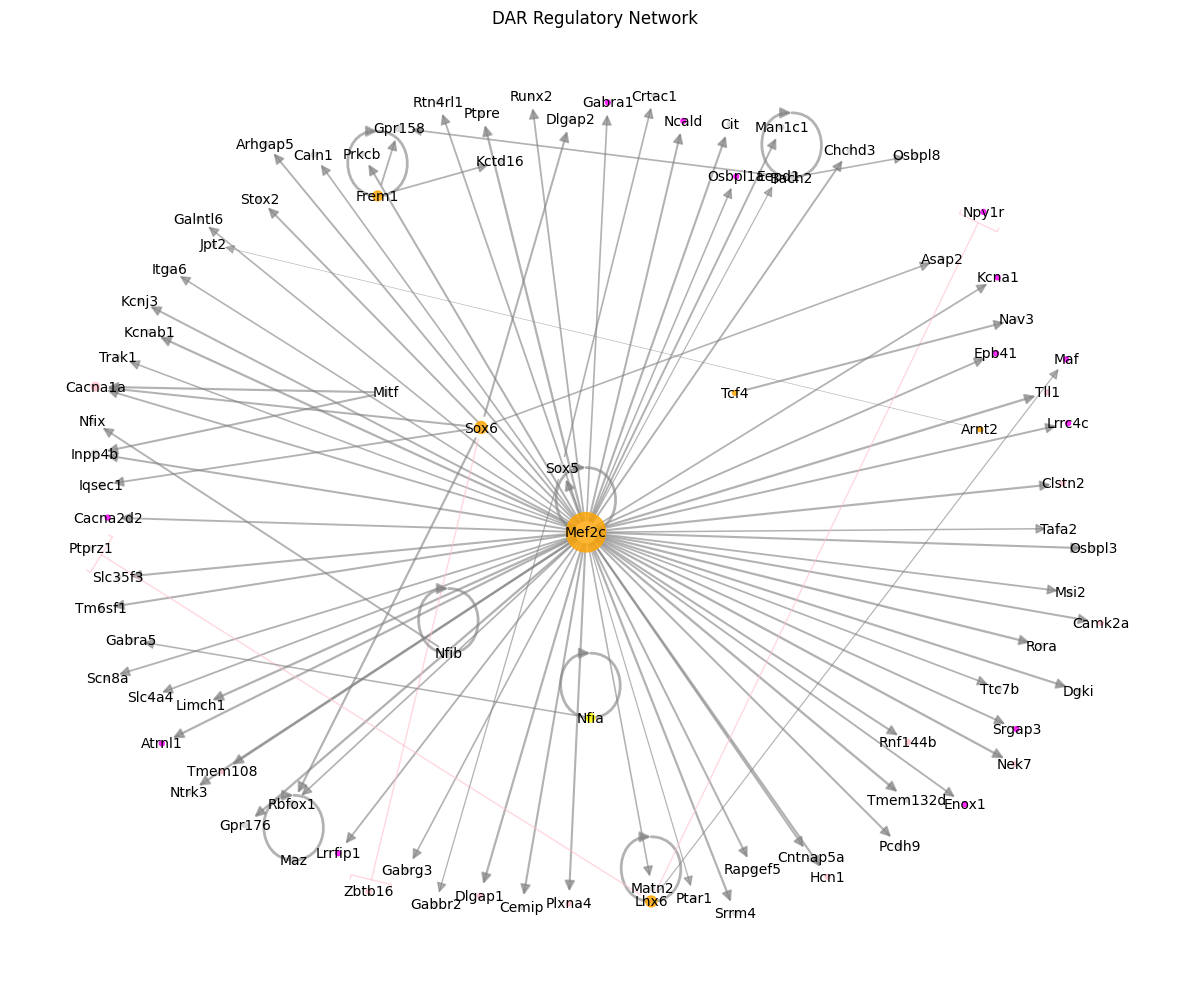

Interactive visualization saved to figures/HIP_HIP_GABA_dar_network.html


In [17]:
dar = direct_er[direct_er.Region.isin(df_dar.names)].copy()
df_dar
visualize_regulatory_network(dar,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=200,title='DAR Regulatory Network',output_html=f'figures/{cellltype}_dar_network.html')


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


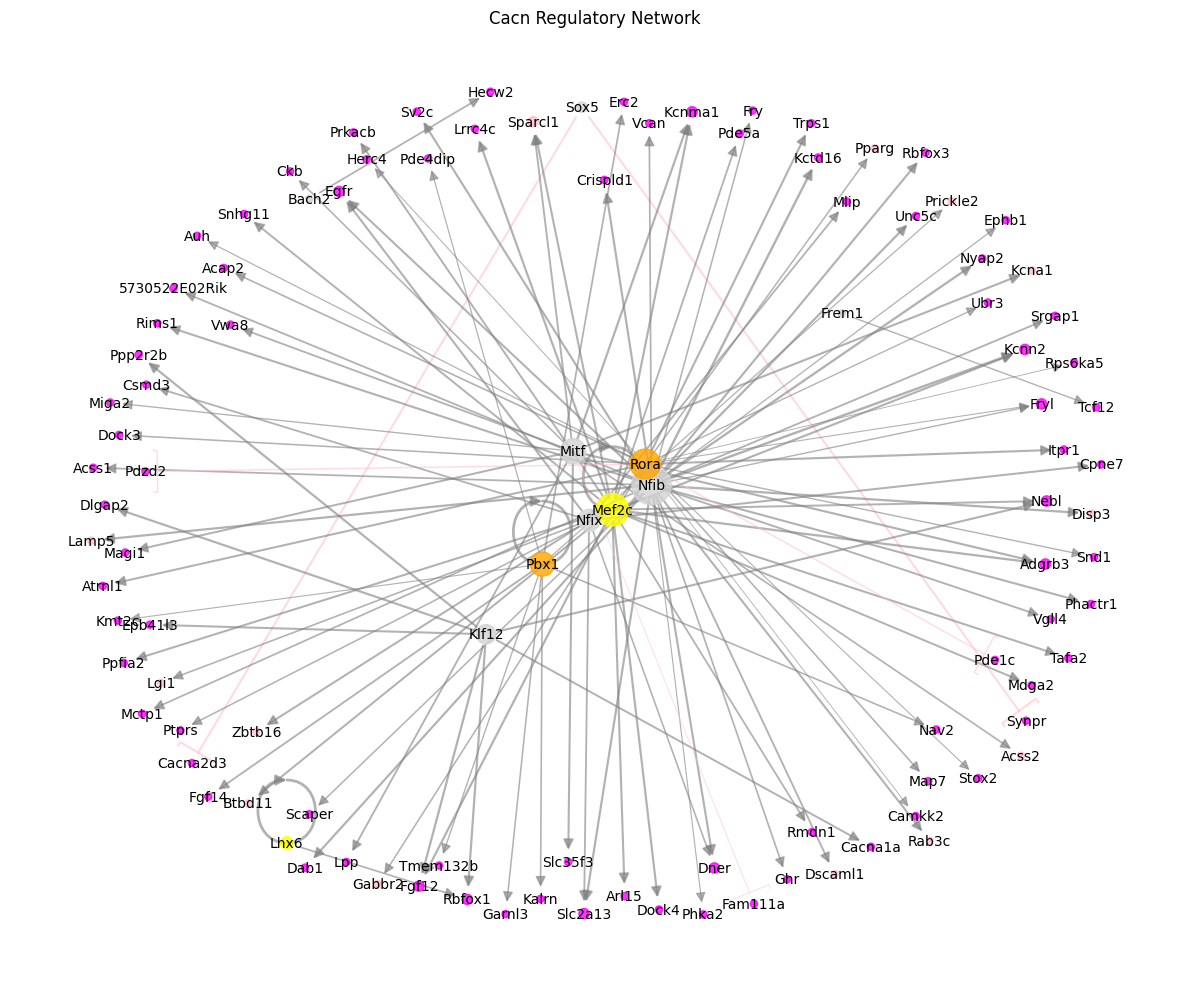

Interactive visualization saved to figures/PFC_PFC_GABA_deg_network.html


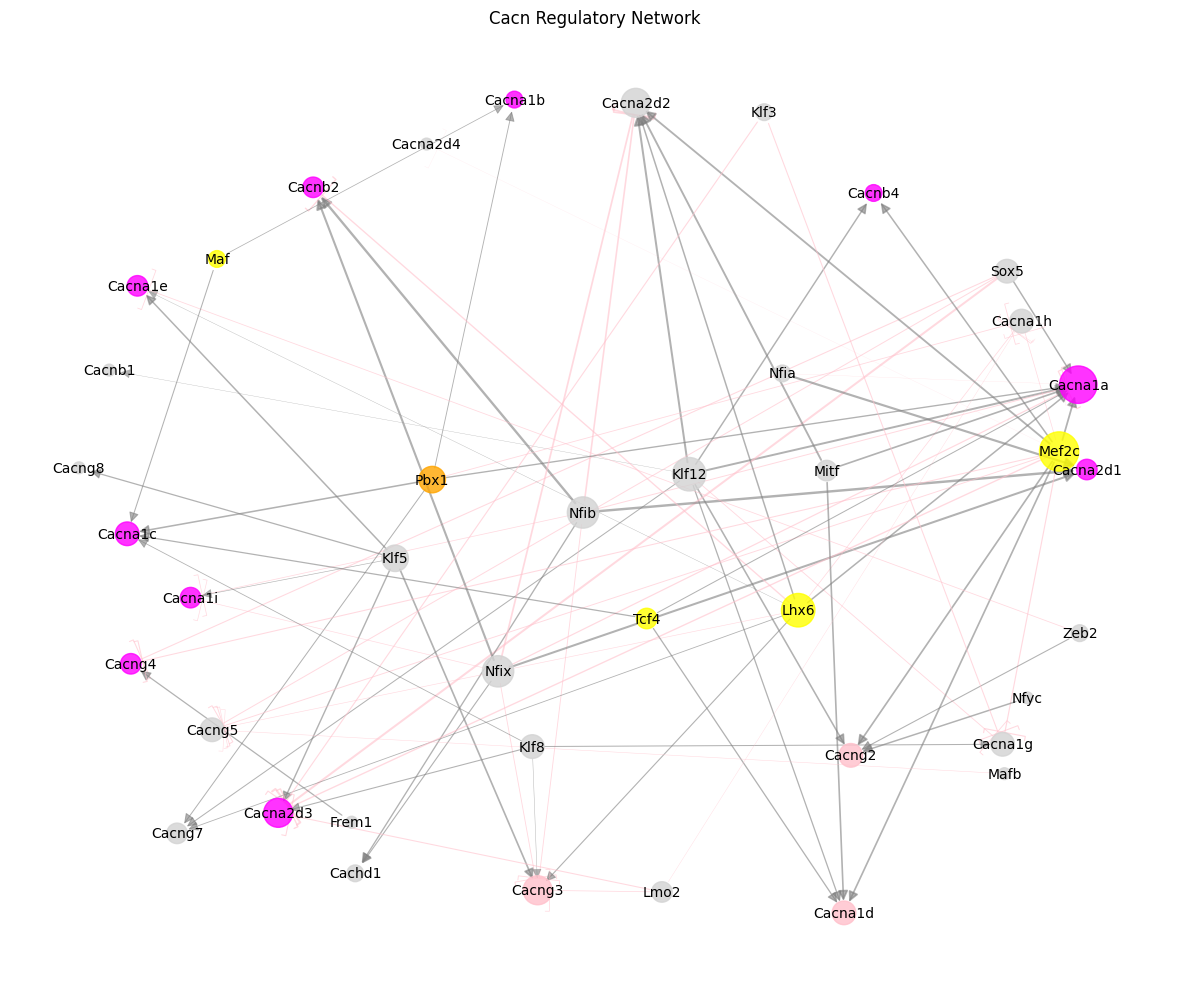

Interactive visualization saved to figures/PFC_PFC_GABA_ca_network.html


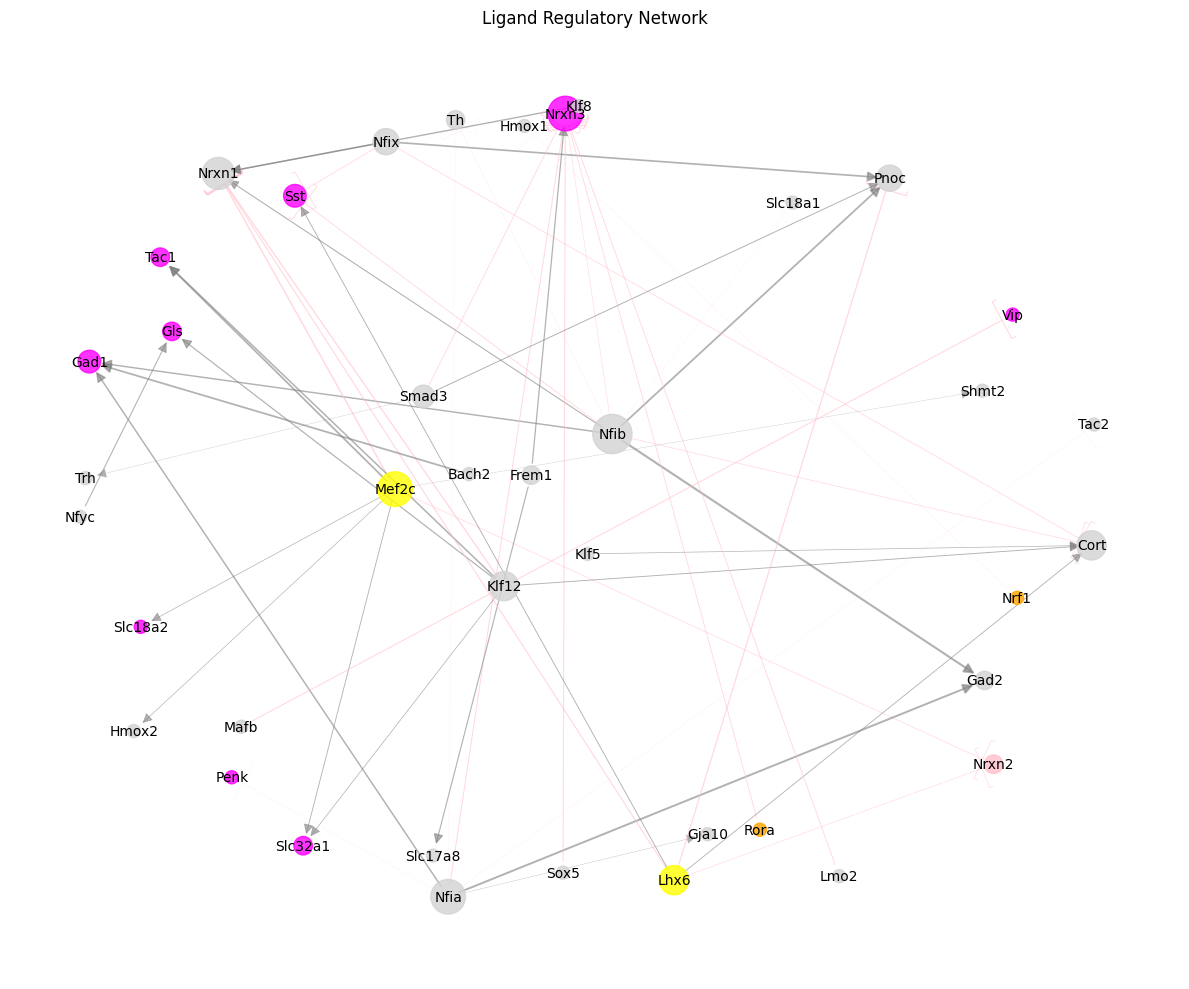

Interactive visualization saved to figures/PFC_PFC_GABA_ligand_network.html


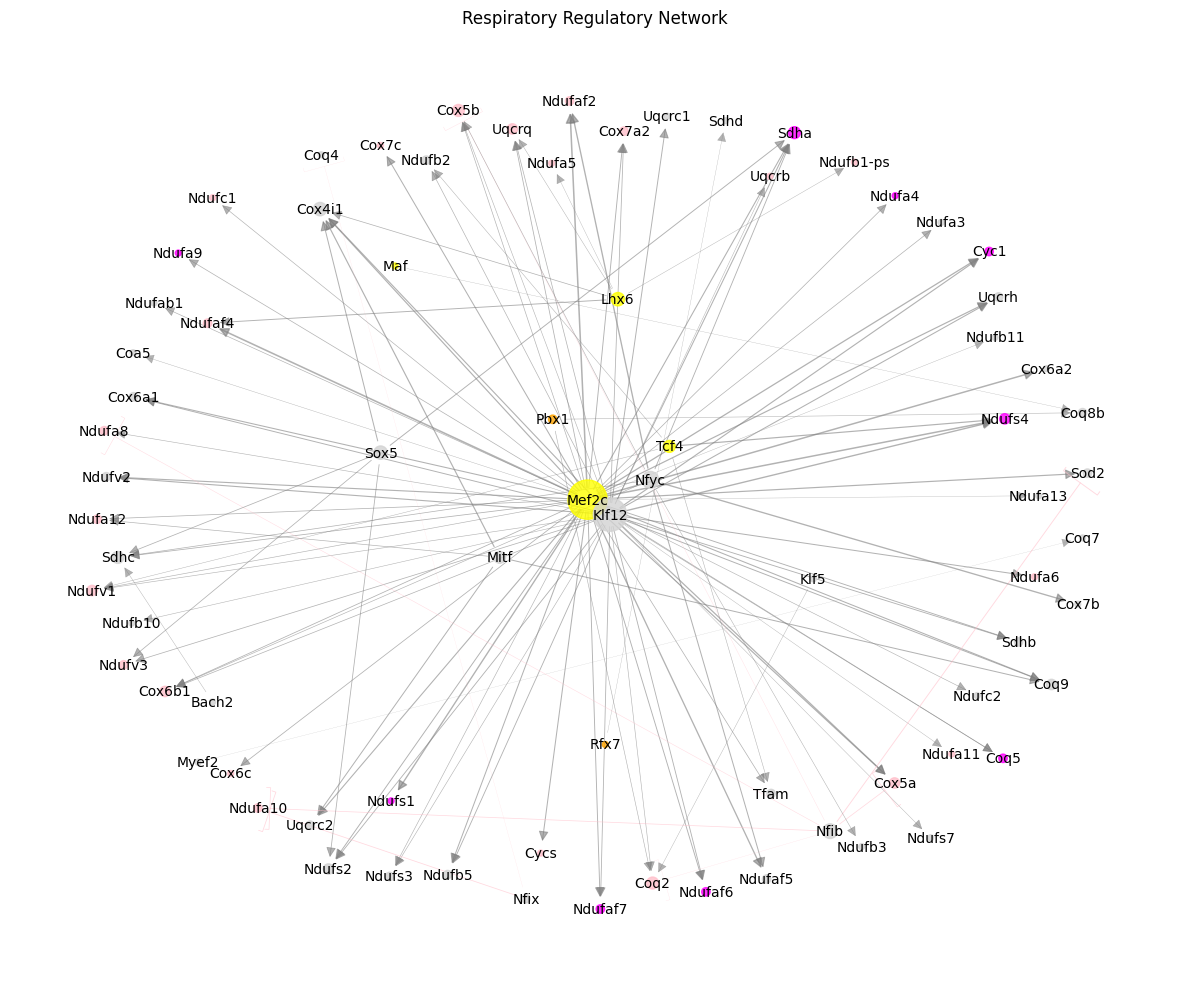

Interactive visualization saved to figures/PFC_PFC_GABA_respiratory_network.html


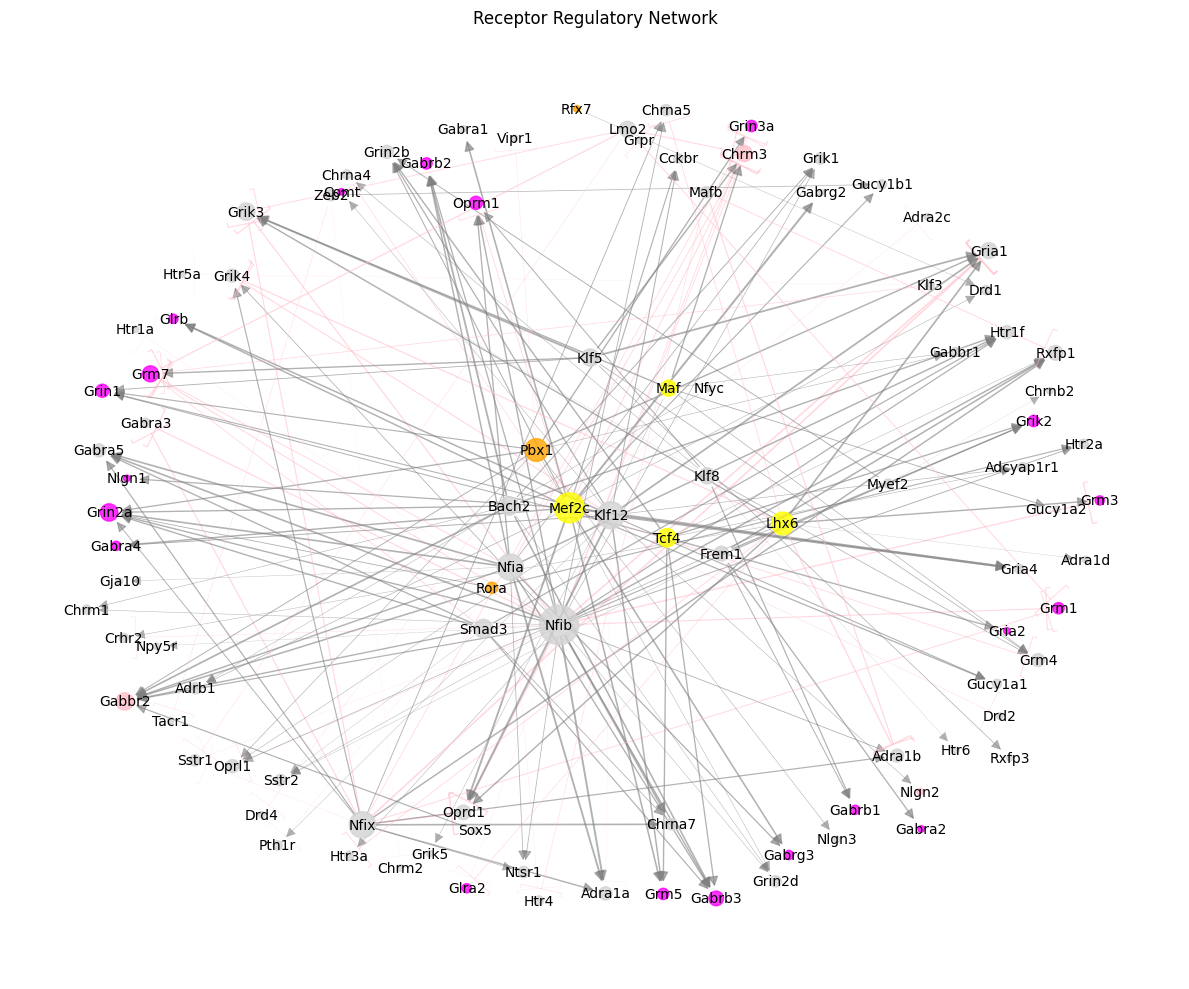

Interactive visualization saved to figures/PFC_PFC_GABA_receptor_network.html


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


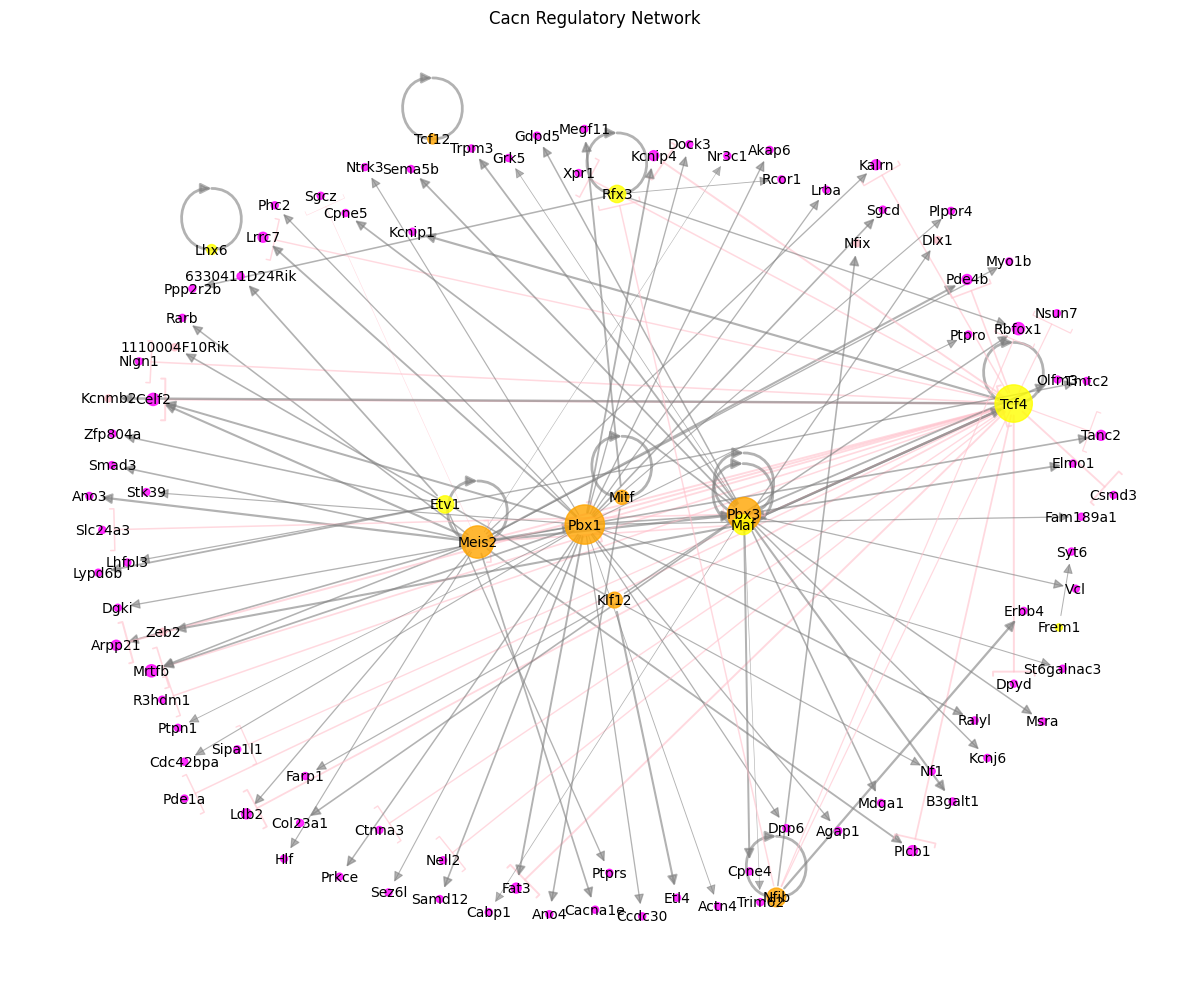

Interactive visualization saved to figures/AMY_AMY_GABA_deg_network.html


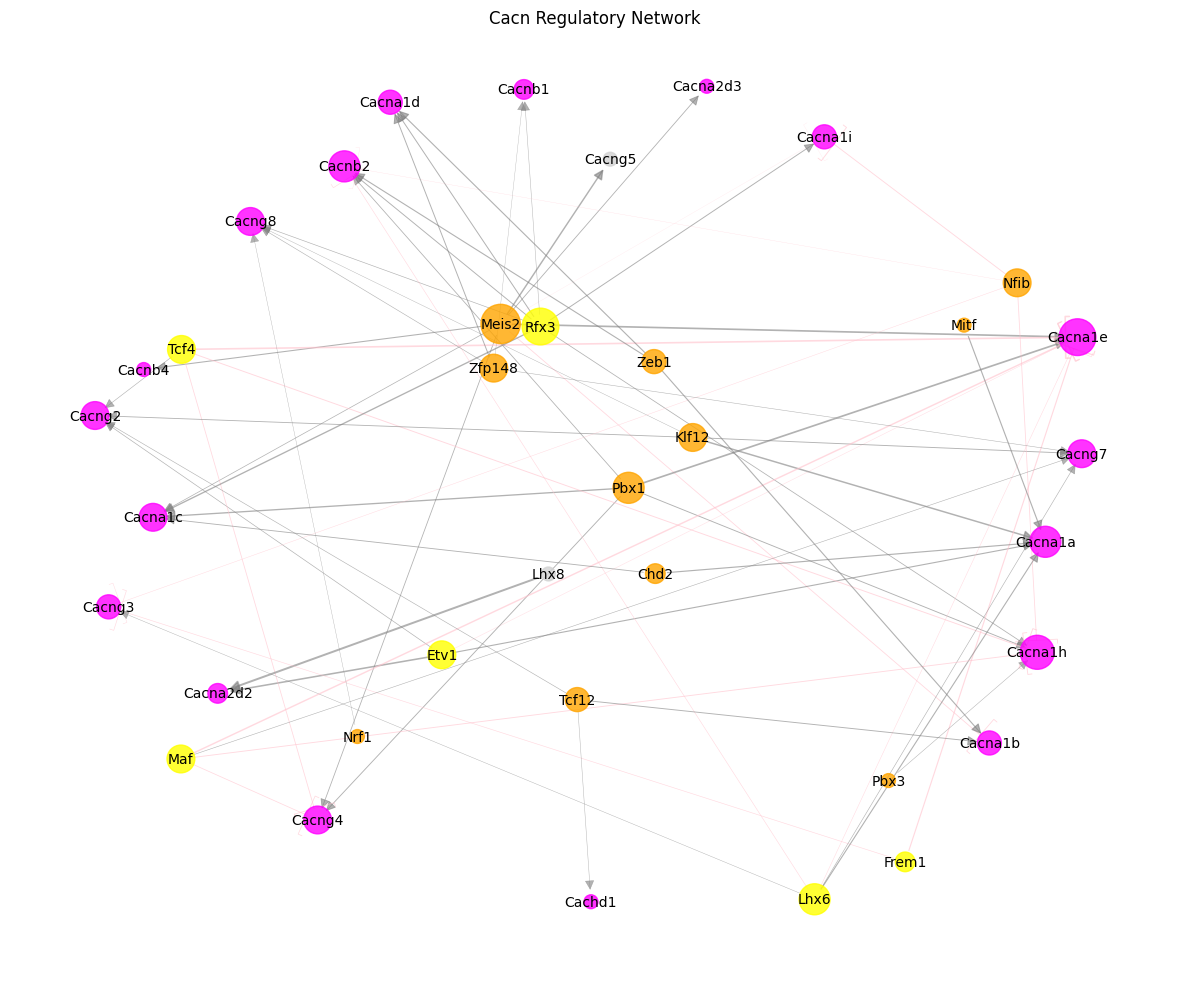

Interactive visualization saved to figures/AMY_AMY_GABA_ca_network.html


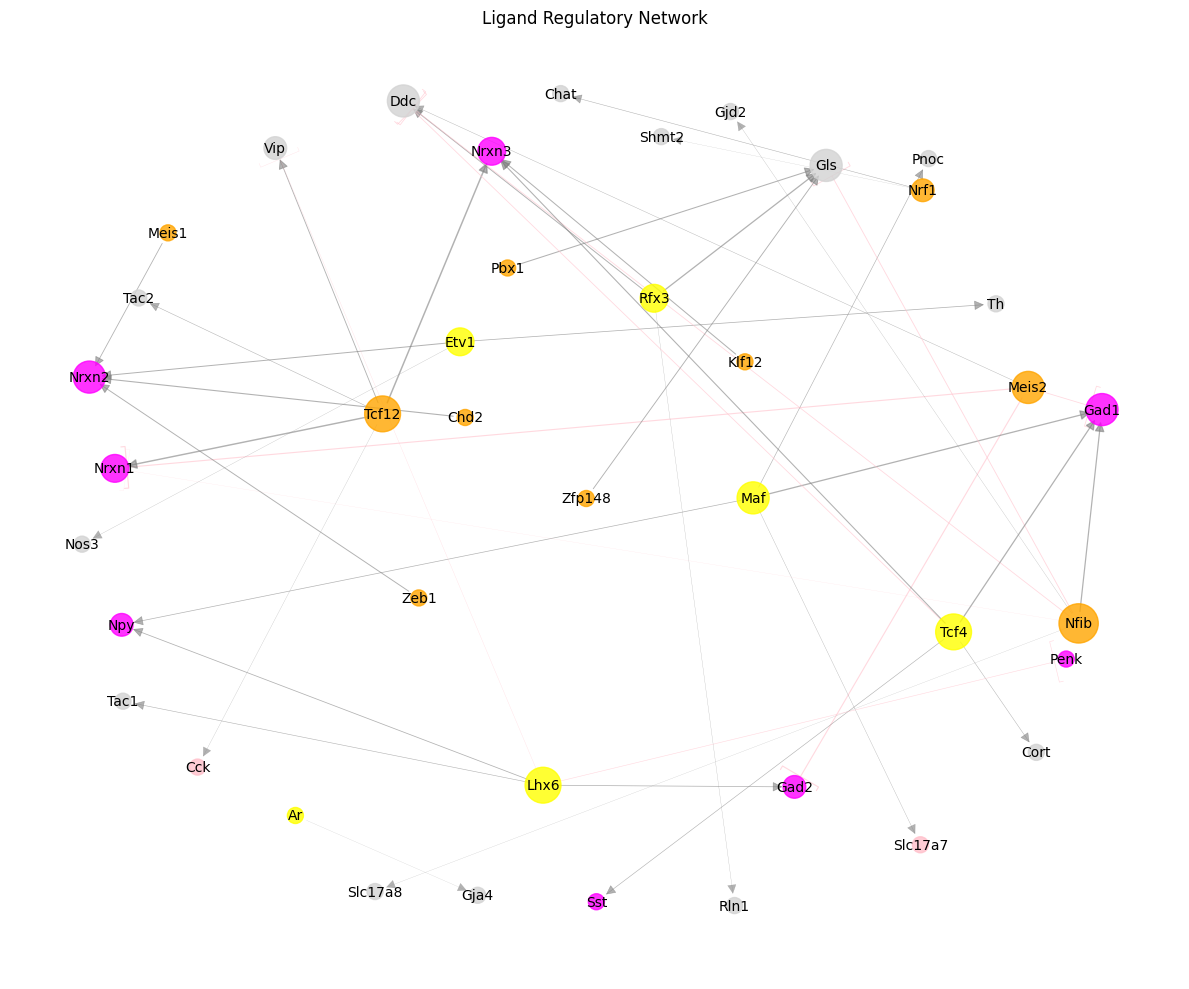

Interactive visualization saved to figures/AMY_AMY_GABA_ligand_network.html


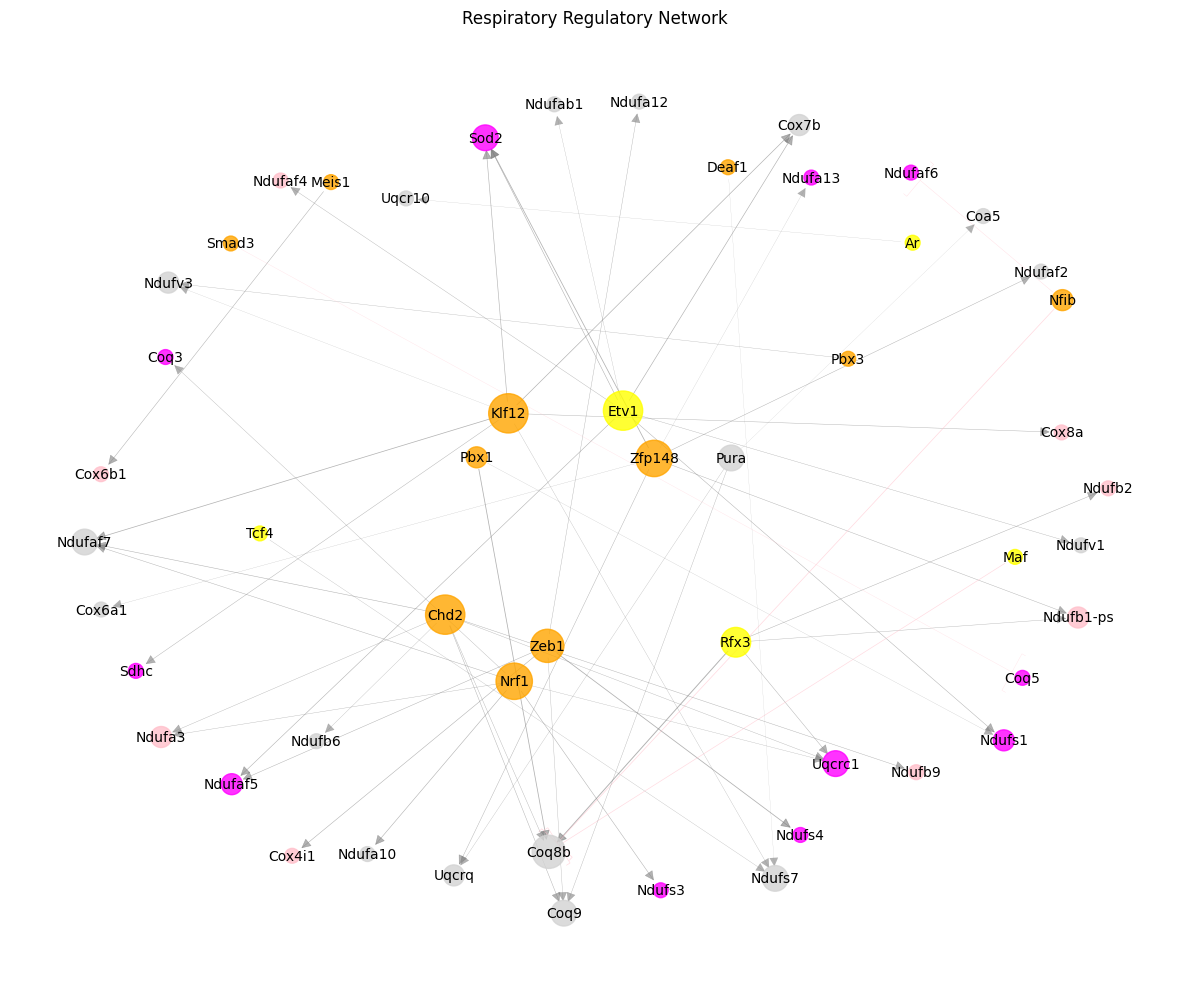

Interactive visualization saved to figures/AMY_AMY_GABA_respiratory_network.html


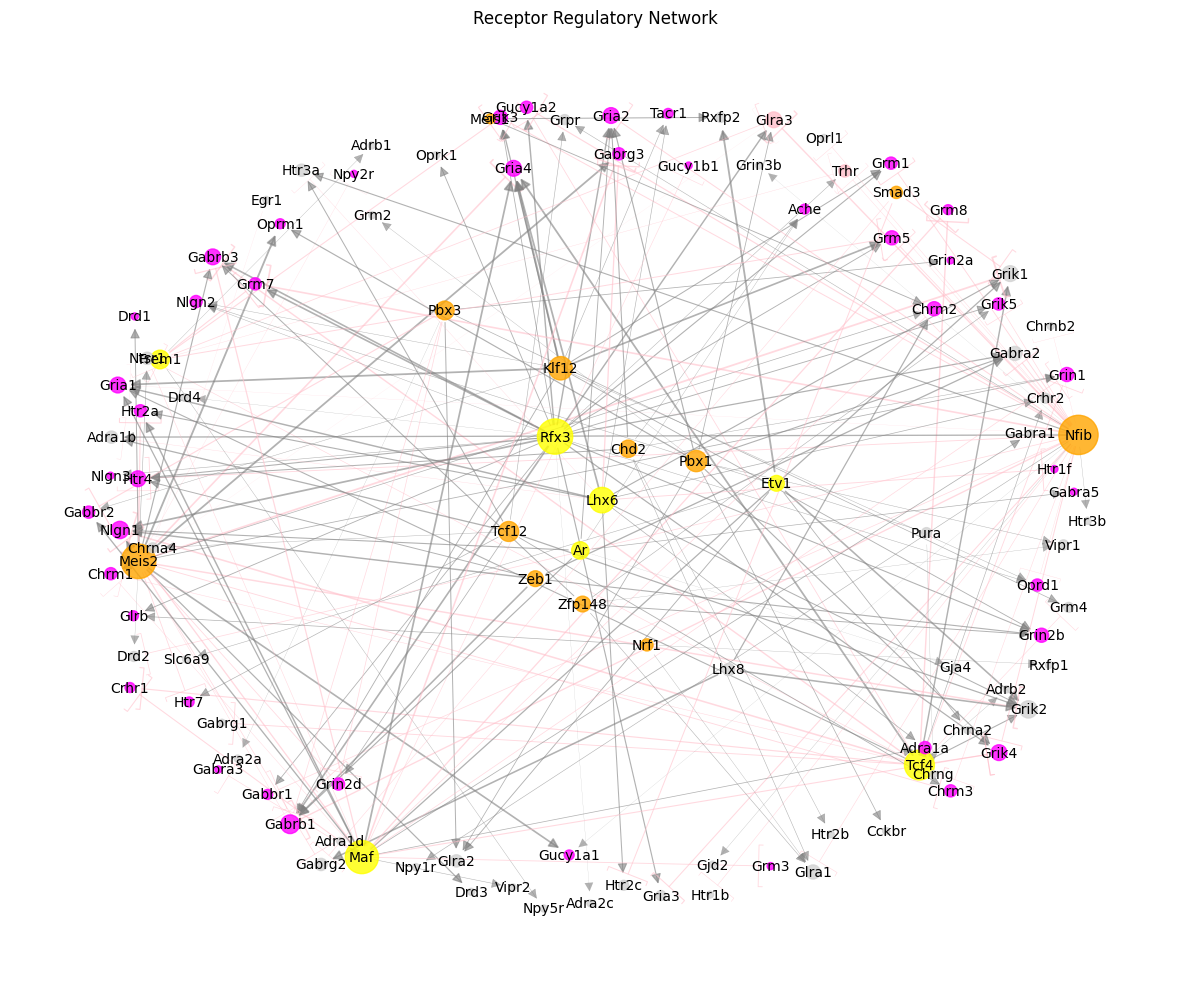

Interactive visualization saved to figures/AMY_AMY_GABA_receptor_network.html


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


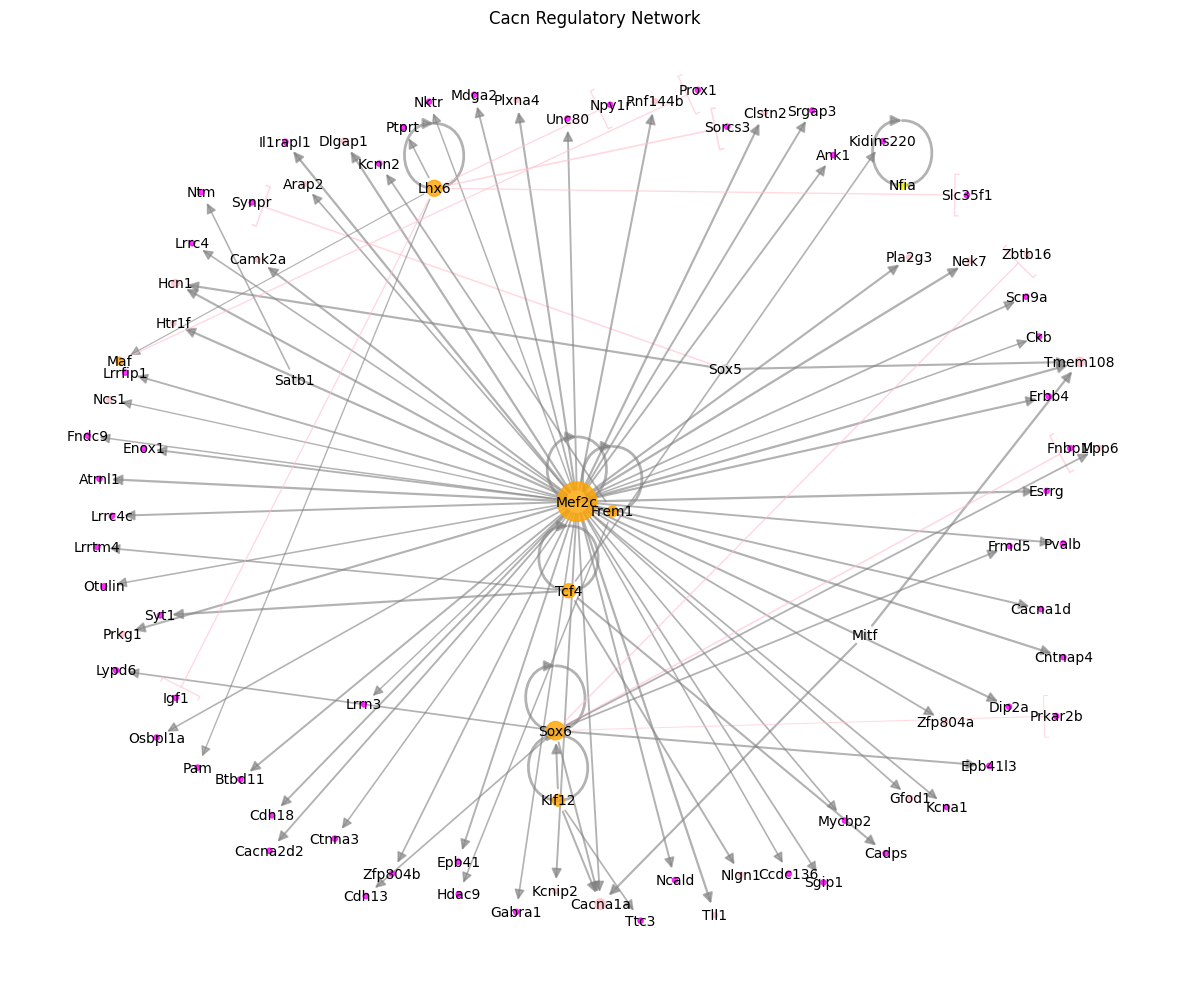

Interactive visualization saved to figures/HIP_HIP_GABA_deg_network.html


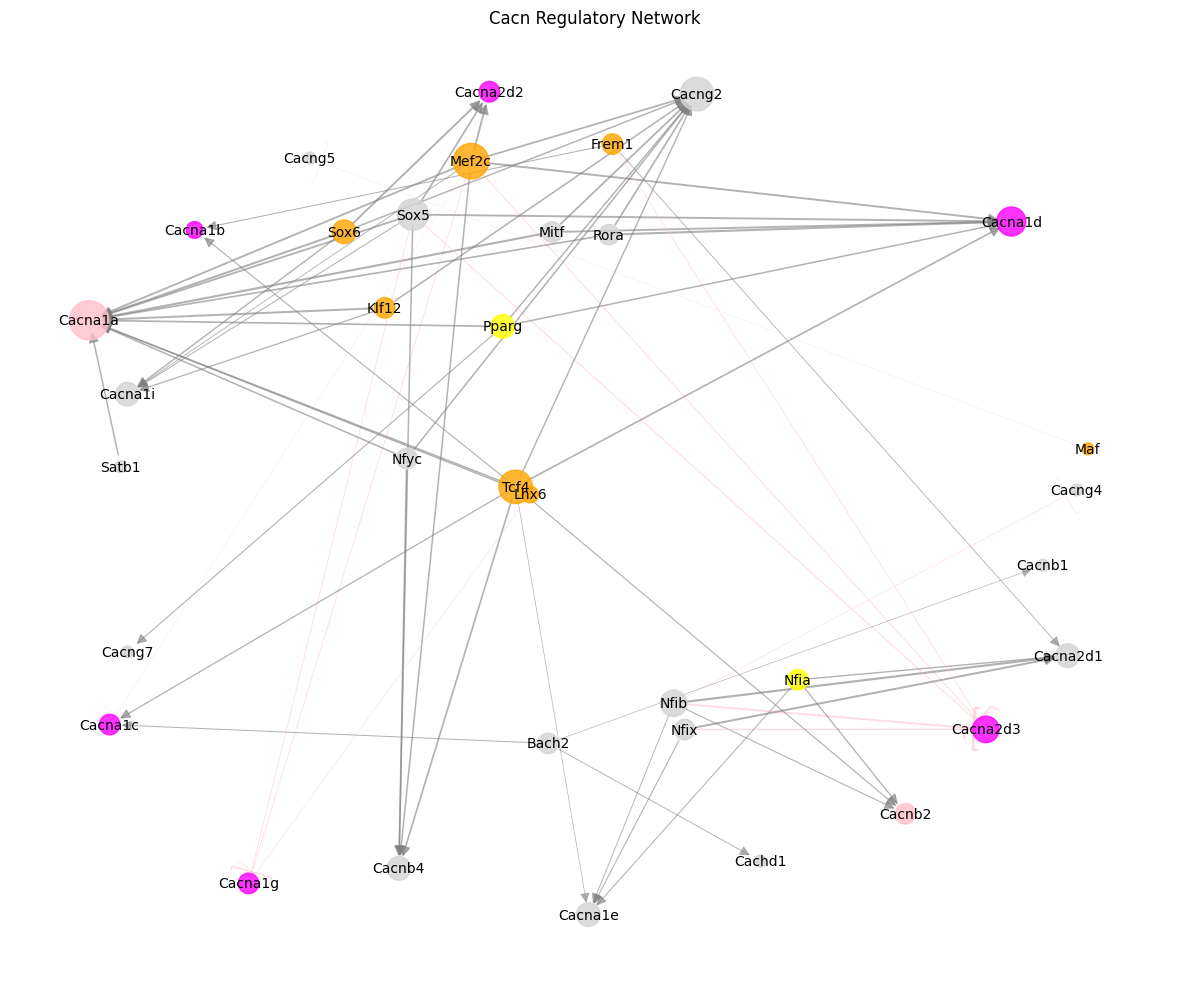

Interactive visualization saved to figures/HIP_HIP_GABA_ca_network.html


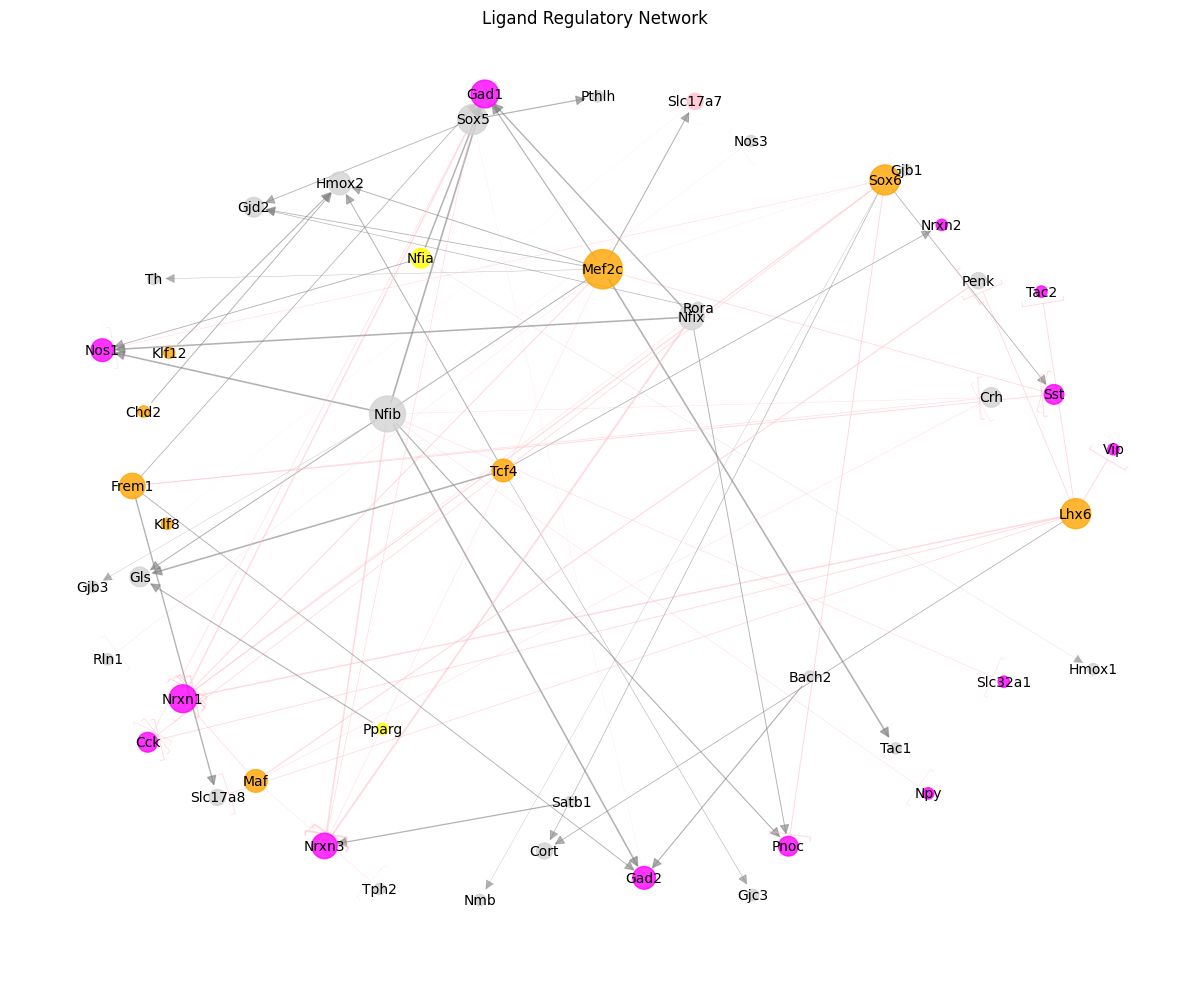

Interactive visualization saved to figures/HIP_HIP_GABA_ligand_network.html


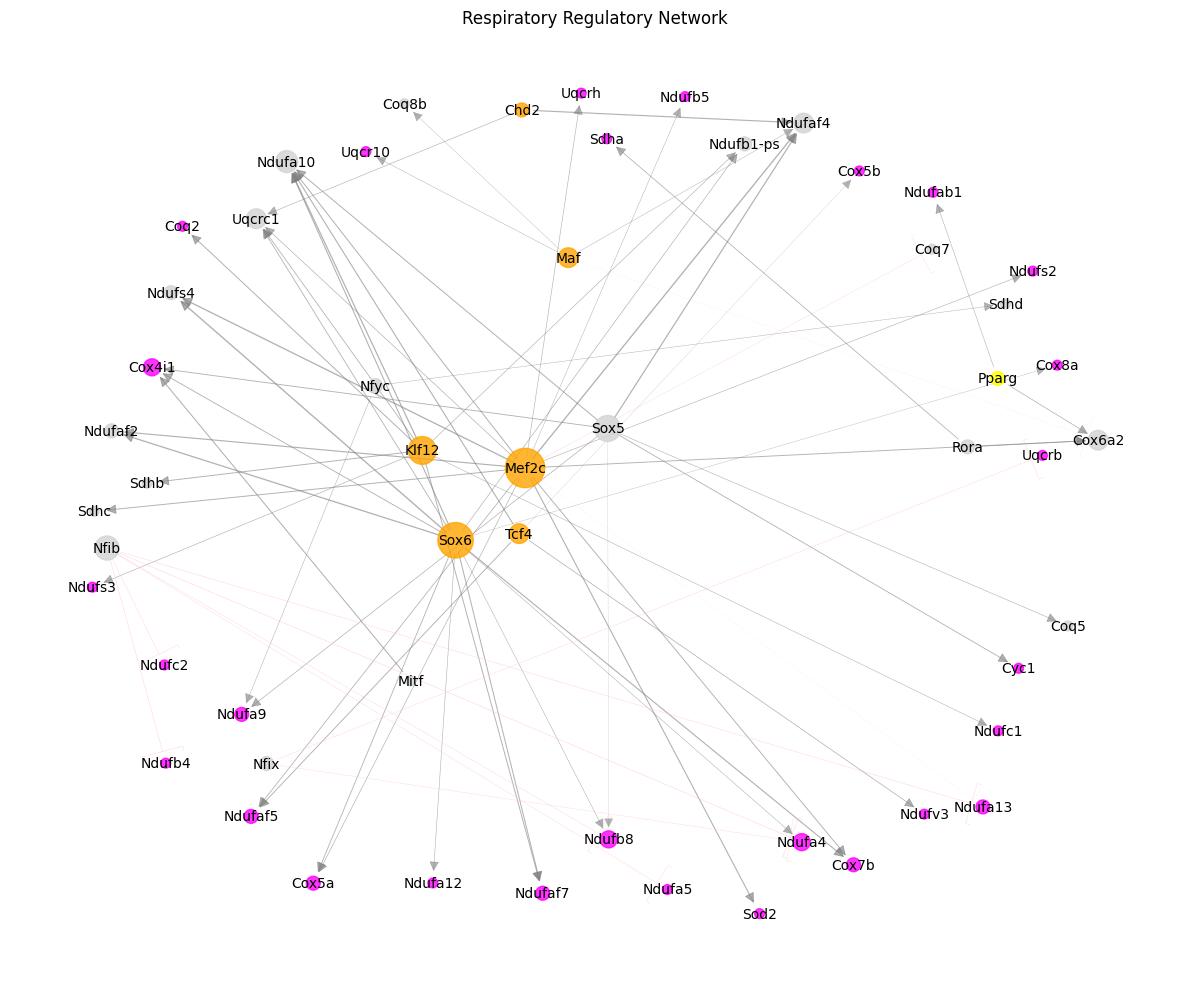

Interactive visualization saved to figures/HIP_HIP_GABA_respiratory_network.html


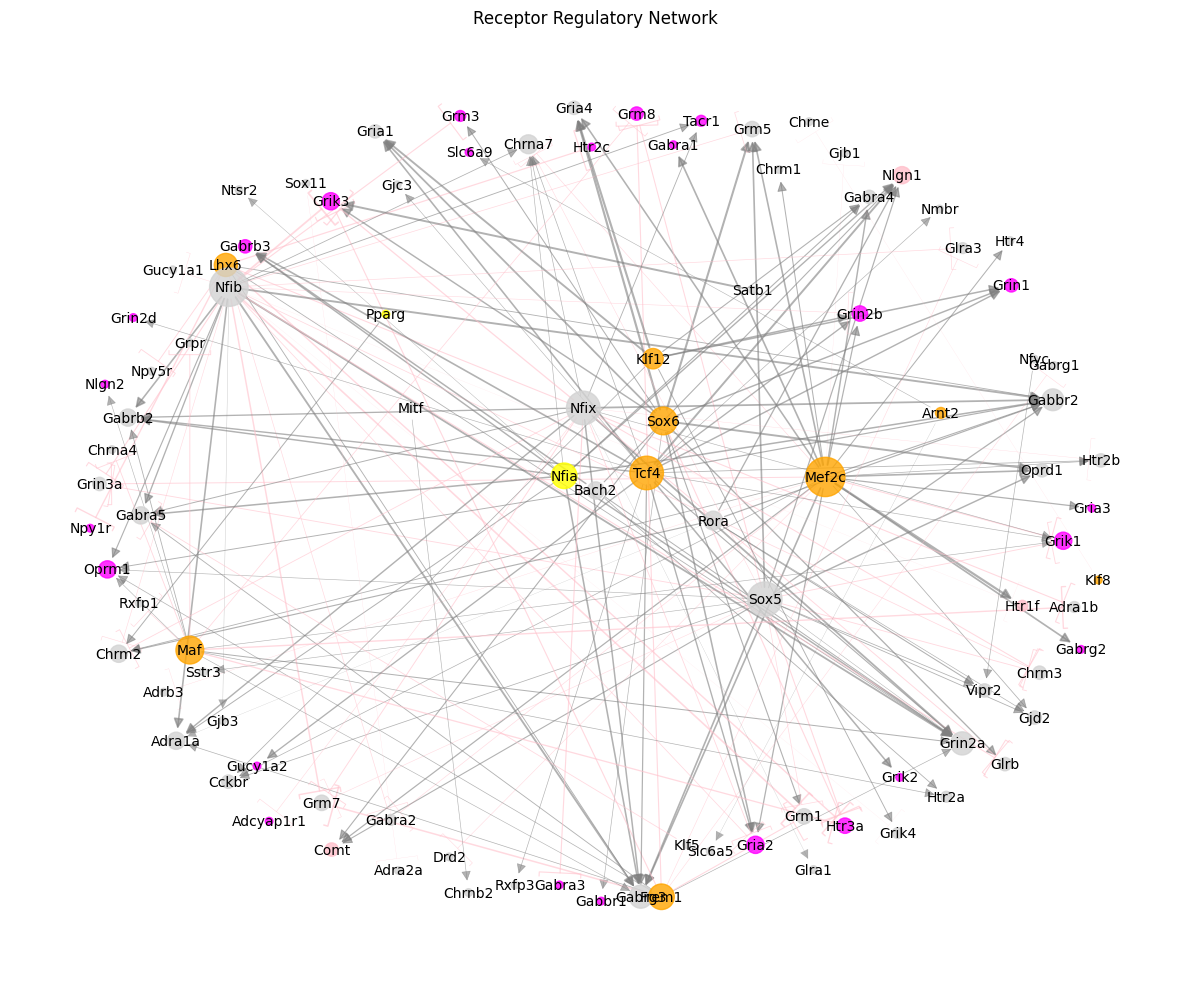

Interactive visualization saved to figures/HIP_HIP_GABA_receptor_network.html


In [6]:
cellltypes = ['PFC_PFC_GABA', 'AMY_AMY_GABA', 'HIP_HIP_GABA']
for cellltype in cellltypes:
    ctname = cellltype[4:]
    df_deg_select = df_deg[df_deg['ctname'] == ctname]
    oudir = f'/data1st2/junyi/output/atac0416/scenic/{cellltype}/Snakemake'
    scplus_mdata = mudata.read(f'{oudir}/scplusmdata.h5mu')

    direct_er = scplus_mdata.uns["direct_e_regulon_metadata"]
    direct_er.sort_values(['importance_TF2G'], ascending=False, inplace=True)
    deg = direct_er[direct_er.Gene.isin(df_deg_select.gene)].copy()
    visualize_regulatory_network(deg,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=400,title='Cacn Regulatory Network',output_html=f'figures/{cellltype}_deg_network.html')

    TF_gcount = pd.DataFrame(direct_er.groupby(['TF']).nunique()['Gene'].sort_values(ascending=False))
    TF_degcount = pd.DataFrame(deg.groupby(['TF']).nunique()['Gene'])
    df_importance = TF_degcount.merge(TF_gcount, left_index=True, right_index=True, how='right', suffixes=('_deg', '_all')).fillna(0)
    df_importance['degratio'] = df_importance['Gene_deg'] / df_importance['Gene_all']
    df_importance.sort_values('degratio', ascending=False, inplace=True)
    df_importance['ctname'] = ctname
    df_importance.to_csv(f'figures/{cellltype}_TF_deg_ratio.csv')
    ca_df = direct_er[direct_er.Gene.isin(ca_genes)].copy()
    visualize_regulatory_network(ca_df,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=len(ca_df),title='Cacn Regulatory Network',output_html=f'figures/{cellltype}_ca_network.html')

    ligand_df = direct_er[direct_er.Gene.isin(ligand)].copy()

    visualize_regulatory_network(ligand_df,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=len(ligand_df),title='Ligand Regulatory Network',df_deg=df_deg_select,output_html=f'figures/{cellltype}_ligand_network.html')

    atp_df = direct_er[direct_er.Gene.isin(respriotory)].copy()

    visualize_regulatory_network(atp_df,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=len(atp_df),title='Respiratory Regulatory Network',output_html=f'figures/{cellltype}_respiratory_network.html')

    receptor_df = direct_er[direct_er.Gene.isin(receptor)].copy()

    visualize_regulatory_network(receptor_df,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=len(receptor_df),title='Receptor Regulatory Network',df_deg=df_deg_select,output_html=f'figures/{cellltype}_receptor_network.html')


In [ ]:
accgex = mudata.read(f'/data1st2/junyi/output/atac0416/scenic/PFC_PFC_GABA/Snakemake/ACC_GEX.h5mu')


In [ ]:
accgex['scRNA'].obs

In [ ]:
scplus_mdata.uns['direct_e_regulon_metadata']

In [ ]:
import glob as glob
df_globs = glob.glob('figures/*_TF**csv')

In [ ]:
all_df = pd.DataFrame()
for df_glob in df_globs:
    df = pd.read_csv(df_glob).head(20)
    
    all_df = pd.concat([all_df, df], axis=0, ignore_index=True)

In [ ]:
all_df.groupby('TF').nunique()['ctname'].sort_values(ascending=False)

In [ ]:


eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)


In [ ]:
scplus_mdata['direct_region_based_AUC'].var

In [ ]:
scplus_mdata['direct_region_based_AUC']

In [ ]:
scplus_mdata.uns["direct_e_regulon_metadata"].to_csv(
    "/data1st2/junyi/output/atac0416/scenic/AMY_AMY_Glut/direct_e_regulon_metadata.csv"
)


In [ ]:
eRegulon_gene_AUC.obs = scplus_mdata.obs.loc[eRegulon_gene_AUC.obs_names]


In [ ]:
sc.pp.neighbors(eRegulon_gene_AUC, use_rep = "X")


In [ ]:
sc.tl.umap(eRegulon_gene_AUC)


In [ ]:
eRegulon_gene_AUC.obs['celltype.L2'] = eRegulon_gene_AUC.obs.index.str.split("_").str[:-1].str.join("_")

In [ ]:
sc.pl.umap(eRegulon_gene_AUC, color = ['celltype.L2'])


In [ ]:
scplus_mdata.obs['celltype.L2'] = scplus_mdata.obs.index.str.split("_").str[:-1].str.join("_")

In [ ]:
from scenicplus.RSS import (regulon_specificity_scores, plot_rss)


In [ ]:
rss = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "celltype.L2",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"]
)


In [ ]:
plot_rss(
    data_matrix = rss,
    top_n = 3,
    num_columns = 3
)

In [ ]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "celltype.L2",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (16, 5)
)